In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, load_npz, save_npz, vstack
import seaborn as sns
import matplotlib.pyplot as plt
import json
from concurrent.futures import ProcessPoolExecutor, as_completed
import anndata
import scanpy as sc
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 145 neuronal subtypes
use_clusters = [
    'CA1 Ak5', 'CA1 Chrm3', 'CA1 Kif26a', 'CA1 Lingo2', 'CA1 Ptprg',
    'CA3 Cadm2', 'CA3 Efnb2', 'CA3-St18 Epha5', 'CA3-St18 Nuak1',
    'CA3-St18 Tead1', 'CGE-Lamp5 Dock5', 'CGE-Lamp5 Grid1', 'CGE-Lamp5 Grk5',
    'CGE-Lamp5 Nrxn3', 'CGE-Lamp5 Sorcs1', 'CGE-Vip Ccser1', 'CGE-Vip Clstn2',
    'CGE-Vip Fstl4', 'CGE-Vip Galnt17', 'CGE-Vip Grm8', 'CGE-Vip Ntng1',
    'CGE-Vip Ptprm', 'CGE-Vip Robo1', 'CLA Bcl11a', 'CLA Cdh8', 'CLA Nrp2',
    'CT-L6 Hcrtr2', 'CT-L6 Il1rap', 'CT-L6 Map4', 'CT-L6 Megf9', 'Chd7 Kcnc2',
    'Chd7 Megf11', 'Chd7 Trpc7', 'D1L-Fstl4 Cadm1', 'D1L-Fstl4 Crim1',
    'D1L-Fstl4 Grm3', 'D1L-Fstl4 Sipa1l2', 'D1L-Fstl4 Trps1', 'D1L-PAL Flrt2',
    'D1L-PAL Plcxd3', 'DG dg-all', 'DG-po Bcl11a', 'DG-po Calb2',
    'DG-po Kctd8', 'EP Adcy8', 'EP Rgs8', 'EP Tspan5', 'Foxp2 Dchs2',
    'Foxp2 Homer2', 'Foxp2 Inpp4b', 'Foxp2 Trpc7', 'Gfra1 Gfra1',
    'IG-CA2 Chrm3', 'IG-CA2 Peak1', 'IG-CA2 Xpr1', 'IT-L23 Cux1',
    'IT-L23 Foxp1', 'IT-L23 Ptprt', 'IT-L23 Tenm2', 'IT-L4 Astn2',
    'IT-L4 Shc3', 'IT-L5 Cdh8', 'IT-L5 Etv1', 'IT-L5 Grik3', 'IT-L6 Cadps2',
    'IT-L6 Fstl4', 'IT-L6 Man1c1', 'IT-L6 Oxr1', 'L6b Adcy8', 'L6b Kcnk2',
    'L6b Nrp2', 'L6b Pkhd1', 'LSX-Inh Cacna1i', 'LSX-Inh Dock10',
    'LSX-Inh Enox1', 'LSX-Inh Foxp2', 'LSX-Inh Lats2', 'LSX-Inh Nxph1',
    'LSX-Inh Zeb2', 'MGE-Pvalb Cacna1i', 'MGE-Pvalb Cnih3', 'MGE-Pvalb Entpd3',
    'MGE-Pvalb Gfra2', 'MGE-Pvalb Ptprk', 'MGE-Pvalb Sema5a',
    'MGE-Pvalb Thsd7a', 'MGE-Sst Bmper', 'MGE-Sst Chodl', 'MGE-Sst Dock4',
    'MGE-Sst Etv1', 'MGE-Sst Frmd6', 'MGE-Sst Kcnip4', 'MGE-Sst Ptpre',
    'MGE-Sst Rerg', 'MGE-Sst Rxra', 'MGE-Sst Ubtd1', 'MGE-Sst Unc5b',
    'MSN-D1 Hrh1', 'MSN-D1 Khdrbs3', 'MSN-D1 Ntn1', 'MSN-D1 Plxnc1',
    'MSN-D2 Casz1', 'MSN-D2 Col14a1', 'MSN-D2 Nrp2', 'MSN-D2 Slc24a2',
    'NP-L6 Boc', 'NP-L6 Cntnap4', 'NP-L6 Cntnap5a', 'NP-L6 Cyp7b1',
    'NP-L6 Kcnab1', 'NP-L6 Olfml2b', 'OLF Gabbr2', 'OLF Kcnd3', 'OLF Mapk10',
    'OLF Pag1', 'OLF Trpc4', 'OLF Xkr6', 'OLF-Exc Bmpr1b', 'OLF-Exc Cdh9',
    'OLF-Exc Cux2', 'OLF-Exc Lrrtm3', 'OLF-Exc Pld5', 'OLF-Exc Rmst',
    'OLF-Exc Sgcd', 'OLF-Exc Unc13c', 'PAL-Inh Chat', 'PAL-Inh Deptor',
    'PAL-Inh Igdcc3', 'PAL-Inh Meis1', 'PAL-Inh Meis2', 'PAL-Inh Onecut2',
    'PAL-Inh Ptprd', 'PAL-Inh Rarb', 'PAL-Inh Tcf7l2', 'PAL-Inh Tmem178',
    'PT-L5 Abca12', 'PT-L5 Astn2', 'PT-L5 Kcnh1', 'PT-L5 Nectin1',
    'PT-L5 Plcb4', 'PT-L5 Ptprt', 'PT-L5 Tenm2', 'PT-L5 Tmtc2', 'PT-L5 Unc5b',
    'Unc5c Unc5c'
]

In [3]:
"""
See here https://stackoverflow.com/questions/52371329/fast-spearman-correlation-between-two-pandas-dataframes

Calculate correlation between two matrix, row by row
"""

from numba import njit
import numpy as np


@njit
def _mean(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].mean()
    return b


@njit
def _std(a):
    n = len(a)
    b = np.empty(n)
    for i in range(n):
        b[i] = a[i].std()
    return b


@njit
def _corr(a, b):
    """
    Correlation between rows in a and b, no nan value
    """
    n, k = a.shape
    m, k = b.shape

    mu_a = _mean(a)
    mu_b = _mean(b)
    sig_a = _std(a)
    sig_b = _std(b)

    out = np.empty((n, m))

    for i in range(n):
        for j in range(m):
            _sig_a = sig_a[i]
            _sig_b = sig_b[j]
            if _sig_a == 0 or _sig_b == 0:
                # if any variable std == 0
                out[i, j] = np.nan
            else:
                out[i, j] = (a[i] - mu_a[i]) @ (b[j] -
                                                mu_b[j]) / k / _sig_a / _sig_b
    return out


def corr(a, b, method='pearson'):
    if method.lower()[0] == 'p':
        pass
    elif method.lower()[0] == 's':
        # turn a, b in to rank matrix
        a = a.argsort(axis=1).argsort(axis=1)
        b = b.argsort(axis=1).argsort(axis=1)
    else:
        raise ValueError('Method can only be pearson or spearman')

    return _corr(a, b)


def chunk_corr(dmr_data, gene_data, mask, cutoff):
    record = corr(a=dmr_data, b=gene_data)
    record[np.abs(record) < cutoff] = 0
    pass_record = csr_matrix(record)
    masked_pass_record = pass_record.multiply(mask)
    return masked_pass_record

In [4]:
chrom = 'chr19'
chunk_size = 5000
cpu = 40
mask_dir = 'DMR_5kb_1M_mask/'

# generate null
dmr_sample = 1000
bin_sample = 1000
repeat = 100

# sig corr
neg_logp_cutoff = 4

In [5]:
# Parameters
chrom = "chrX"
chunk_size = 5000
cpu = 40


## Load Data

In [6]:
dmr_df = pd.read_msgpack(
    f'/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/DMR_rate/SubDMR_rate_no_na.{chrom}.msg'
)
chrombin_df = pd.read_msgpack(
    f'/home/hanliu/project/mouse_rostral_brain/study/DMRChromBinCorr/SubTypeBins/SubType_5kb_mCH_per_chrom/{chrom}.msg'
)
dist_mask_adata = anndata.read_h5ad(
    f'/home/hanliu/project/mouse_rostral_brain/study/DMRChromBinCorr/{mask_dir}/{chrom}.h5ad'
)
dist_mask = dist_mask_adata[:, chrombin_df.index].X

# reindex chrombin_df
use_cols = pd.Index(use_clusters)
dmr_df.columns = dmr_df.columns.map(lambda i: i.replace('_', ' '))
chrombin_df.columns = chrombin_df.columns.map(lambda i: i.replace('_', ' '))
dmr_df = dmr_df[use_cols].copy()
chrombin_df = chrombin_df[use_cols].copy()

cluster_mcg = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/ClusterGlobalmCG.csv',
    index_col=0,
    header=None,
    squeeze=True).loc[use_cols]
cluster_mch = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/study/DMRGeneCorr/ClusterGlobalmCH.csv',
    index_col=0,
    header=None,
    squeeze=True).loc[use_cols]

# standardize global
cluster_mcg = (cluster_mcg - cluster_mcg.mean()) / cluster_mcg.std()
cluster_mch = (cluster_mch - cluster_mch.mean()) / cluster_mch.std()

print(dmr_df.shape[0], 'DMRs')
print(chrombin_df.shape[0], 'Genes')

187296 DMRs
28829 Genes


In [7]:
assert dmr_df.shape[0] == dist_mask.shape[0]
assert chrombin_df.shape[0] == dist_mask.shape[1]

## Regress Out DMR global corr
- Global mCH
- Global mCG

In [8]:
dmr_adata = anndata.AnnData(X=dmr_df.values.T,
                obs=pd.DataFrame([], index=dmr_df.columns),
                var=pd.DataFrame([], index=dmr_df.index))

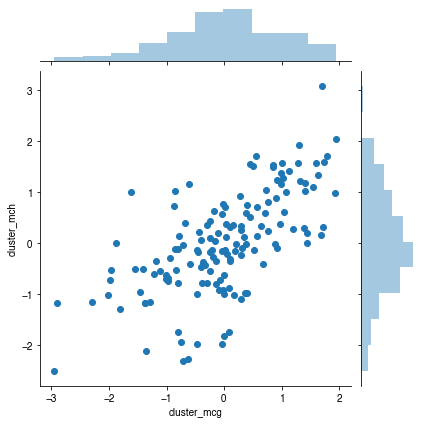

In [9]:
dmr_adata.obs['cluster_mch'] = cluster_mch
dmr_adata.obs['cluster_mcg'] = cluster_mcg

sns.jointplot(x=dmr_adata.obs['cluster_mcg'], y=dmr_adata.obs['cluster_mch'])

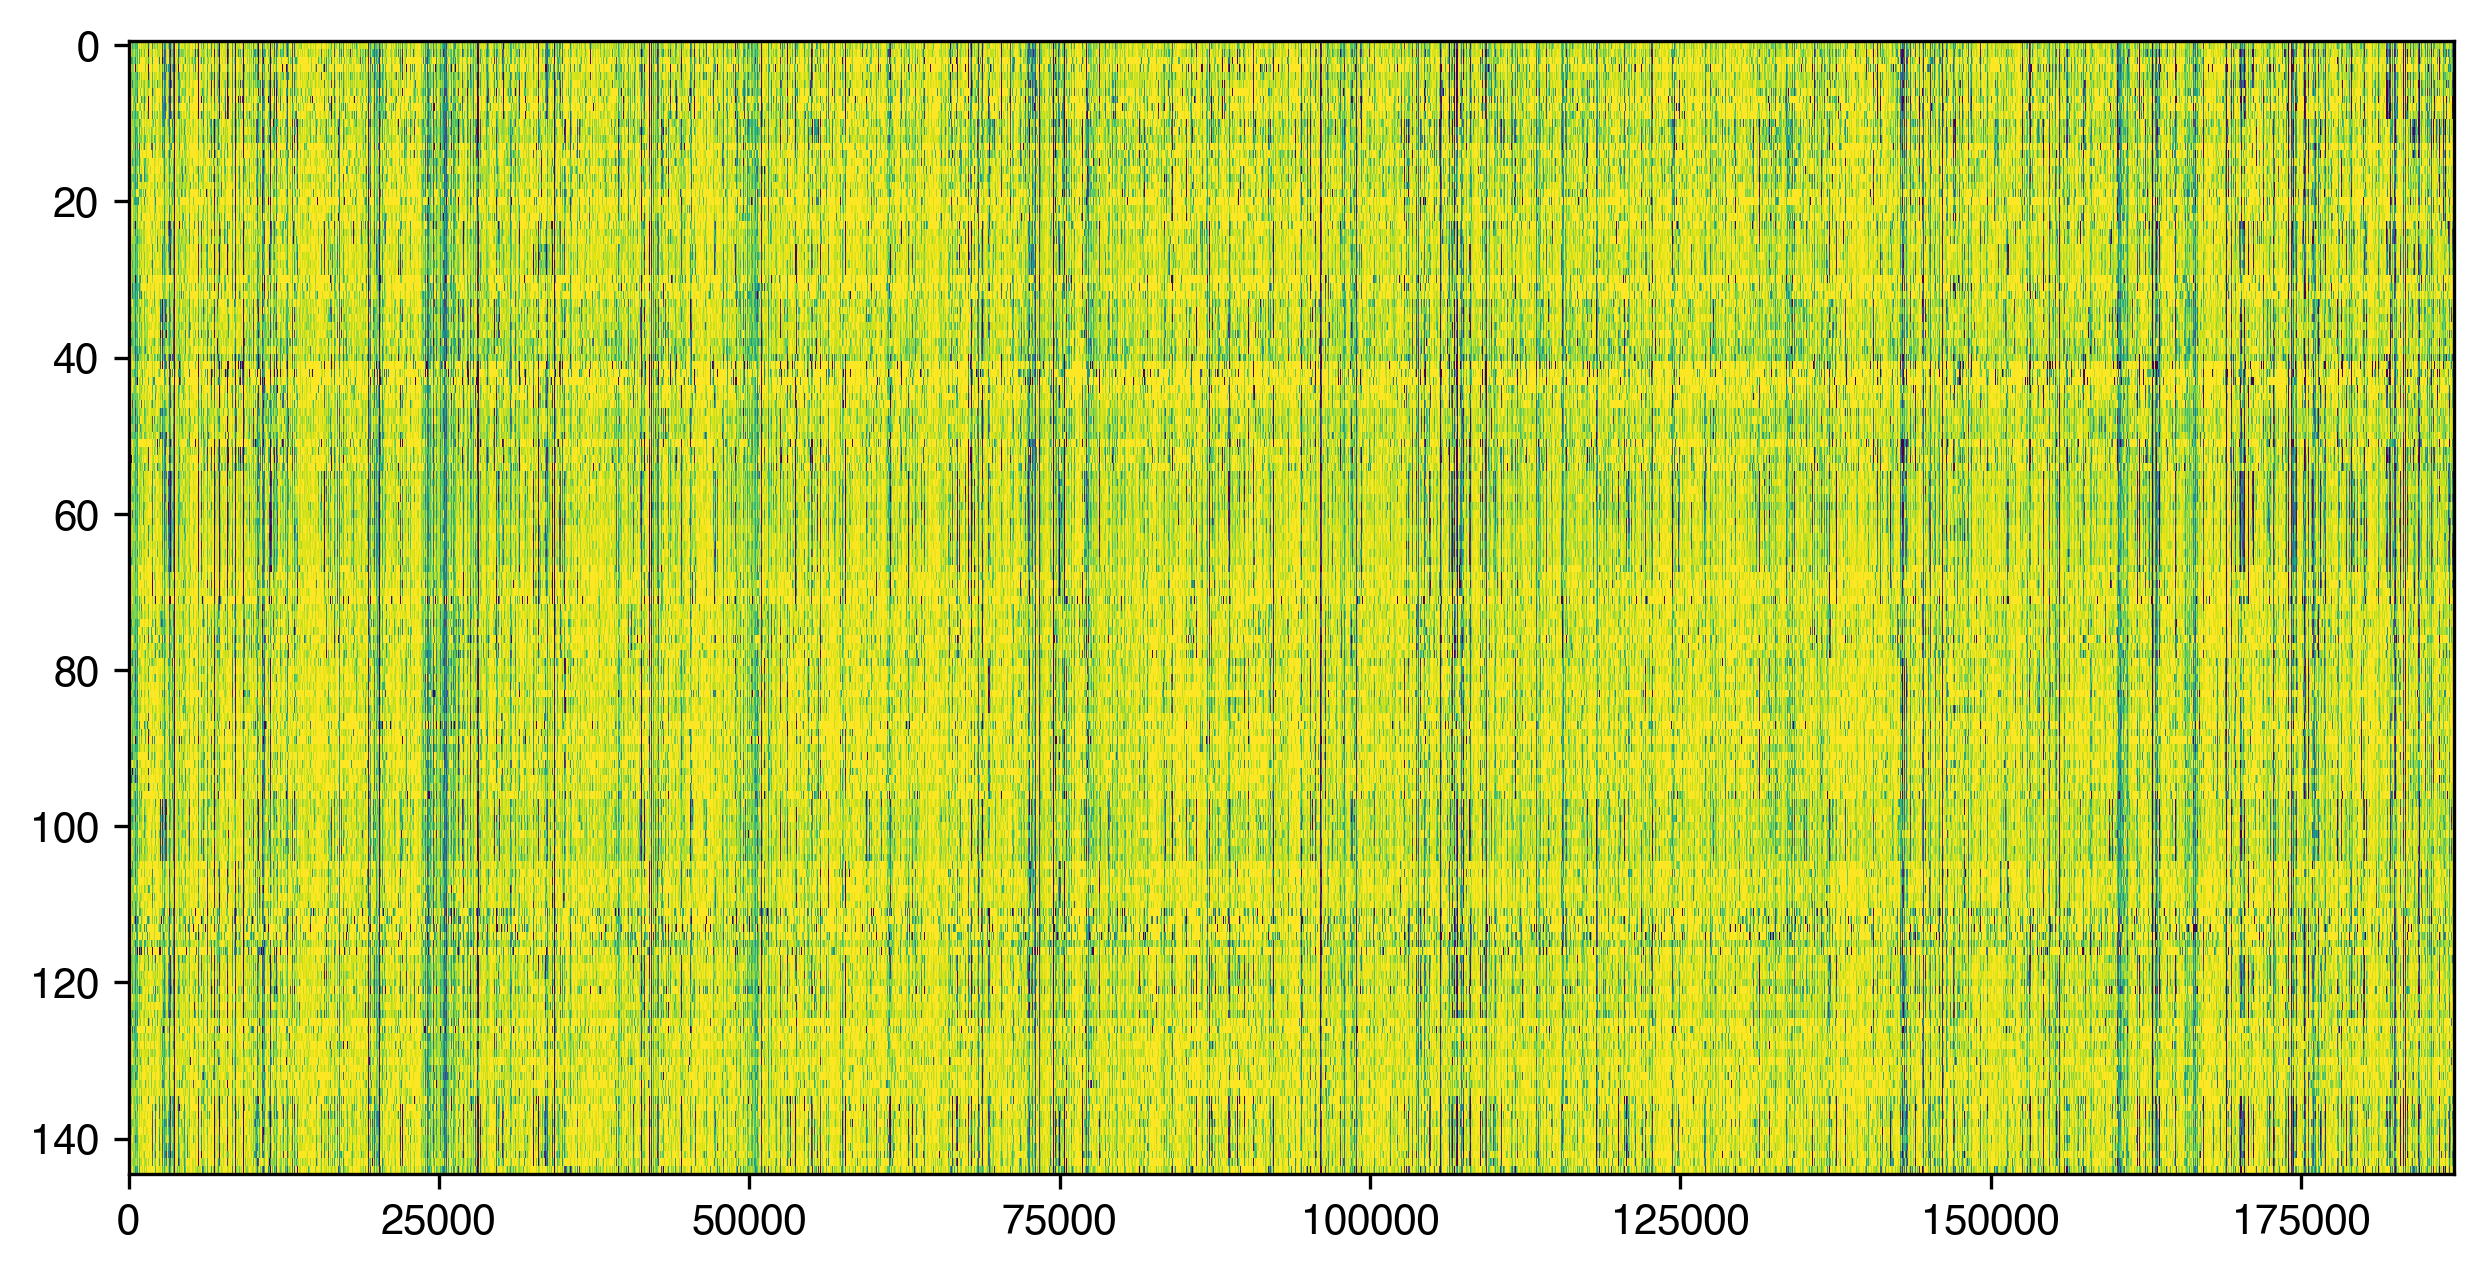

In [10]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(dmr_adata.X, aspect='auto', vmin=0, vmax=1)

In [11]:
# remove dmr that has 0 std
# otherwise regress out will fail.
dmr_adata = dmr_adata[:, dmr_adata.X.std(axis=0) > 0].copy()

# since this may change the shape of dmr_adata, reindex mask as well
dist_mask = dist_mask[dmr_adata.X.std(axis=0) > 0, :]

In [12]:
sc.pp.regress_out(dmr_adata, 
                  keys=['cluster_mch', 'cluster_mcg'], 
                  n_jobs=cpu)

In [13]:
scaler = StandardScaler(copy=False)
dmr_adata.X = scaler.fit_transform(dmr_adata.X)

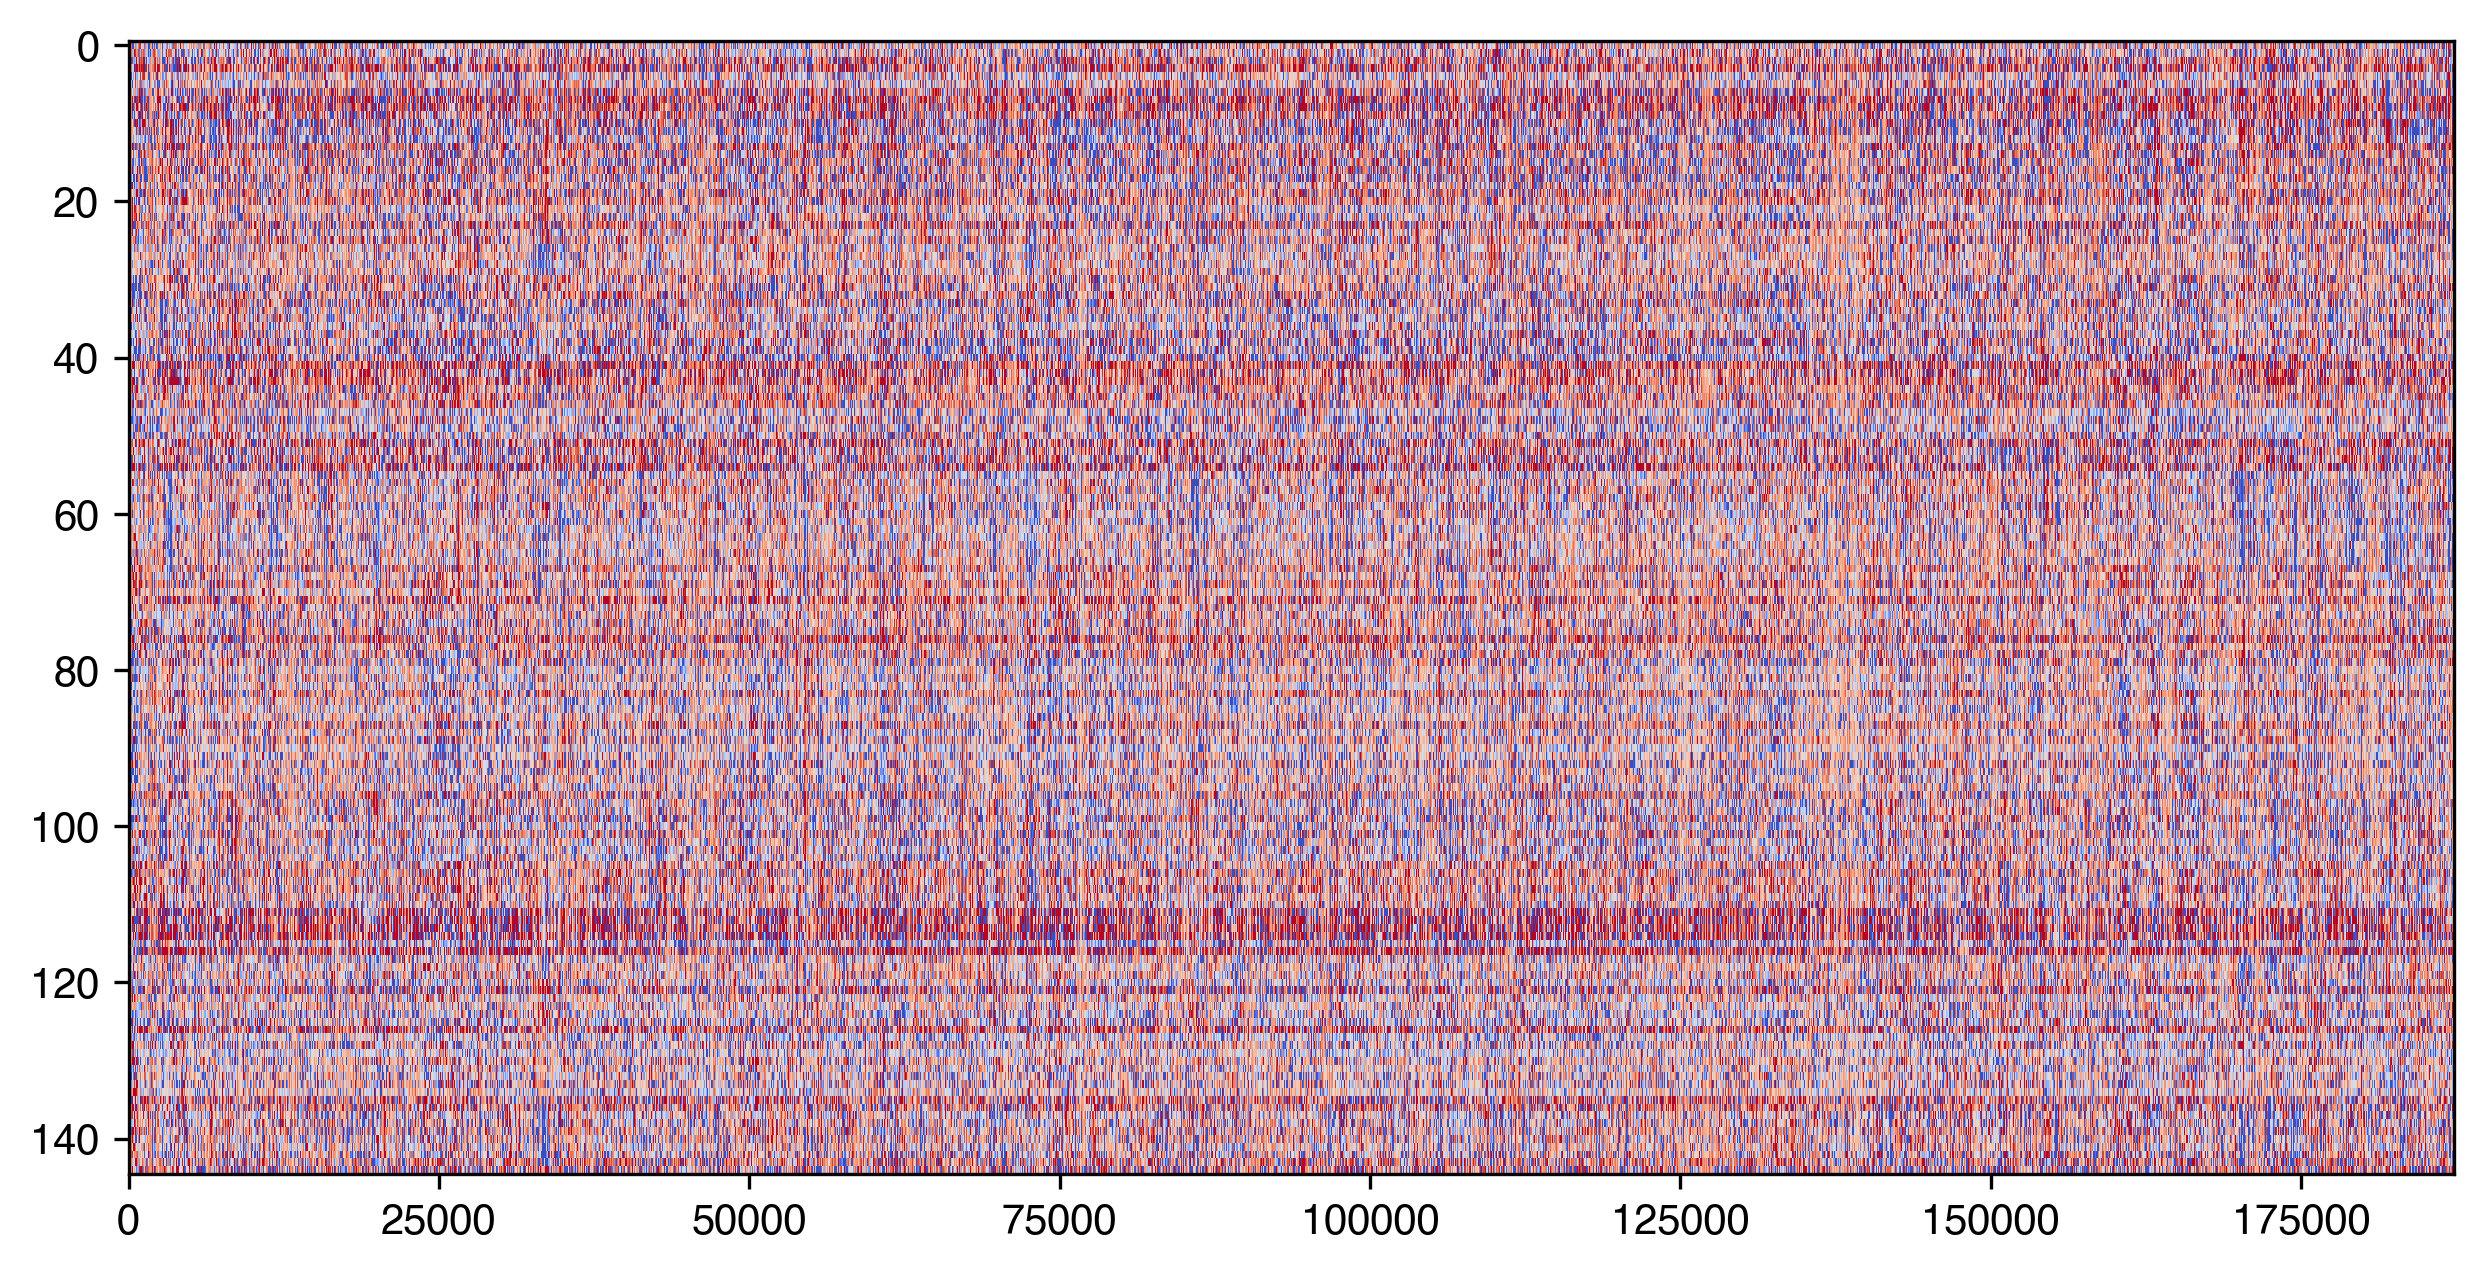

In [14]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(dmr_adata.X, aspect='auto', cmap='coolwarm', 
           vmin=-1, vmax=1)

## Regress Out Gene Global Corr

In [15]:
chrombin_adata = anndata.AnnData(X=chrombin_df.values.T,
                obs=pd.DataFrame([], index=chrombin_df.columns),
                var=pd.DataFrame([], index=chrombin_df.index))

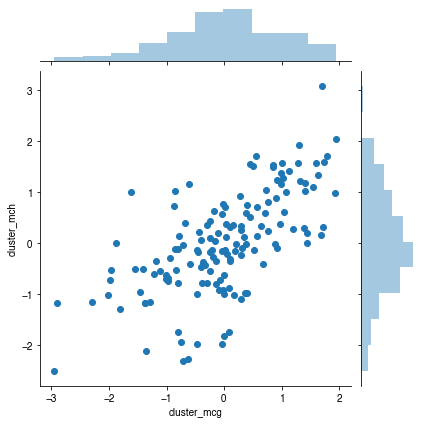

In [16]:
chrombin_adata.obs['cluster_mch'] = cluster_mch
chrombin_adata.obs['cluster_mcg'] = cluster_mcg

sns.jointplot(x=chrombin_adata.obs['cluster_mcg'], 
              y=chrombin_adata.obs['cluster_mch'])

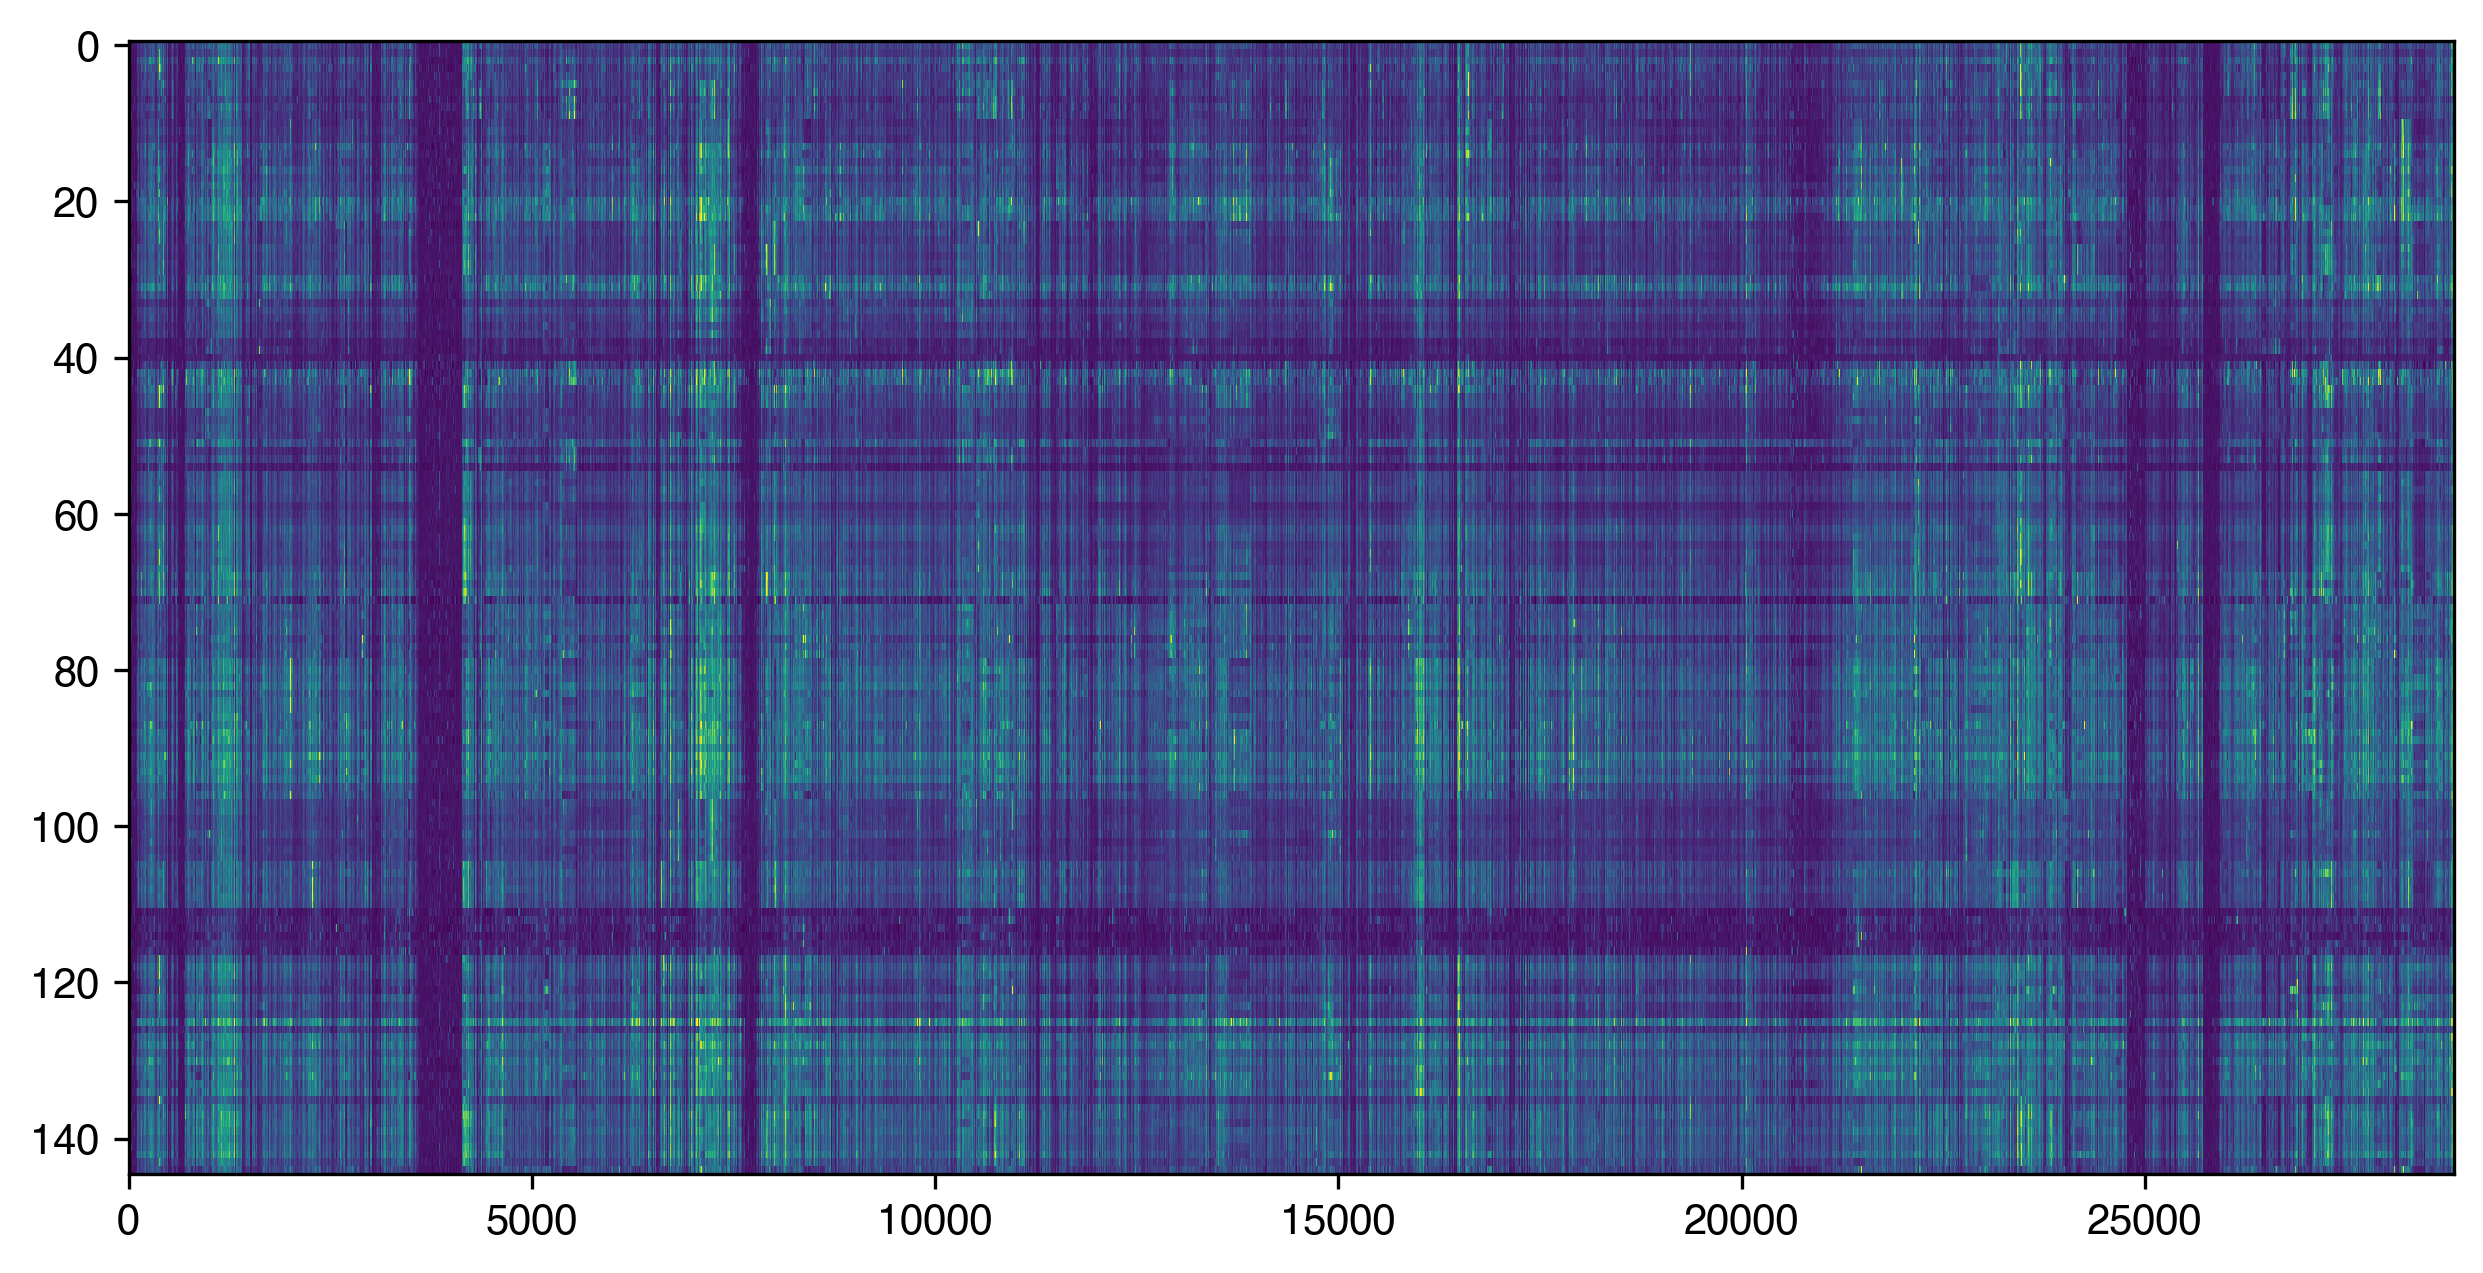

In [17]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(chrombin_adata.X, aspect='auto', vmin=0, vmax=0.1)

In [18]:
# remove dmr that has 0 std
# otherwise regress out will fail.
chrombin_adata = chrombin_adata[:, chrombin_adata.X.std(axis=0) > 0].copy()

# since this may change the shape of dmr_adata, reindex mask as well
dist_mask = dist_mask[:, chrombin_adata.X.std(axis=0) > 0]

In [19]:
sc.pp.regress_out(chrombin_adata, 
                  keys=['cluster_mch', 'cluster_mcg'], 
                  n_jobs=cpu)


In [20]:
scaler = StandardScaler(copy=False)
chrombin_adata.X = scaler.fit_transform(chrombin_adata.X)

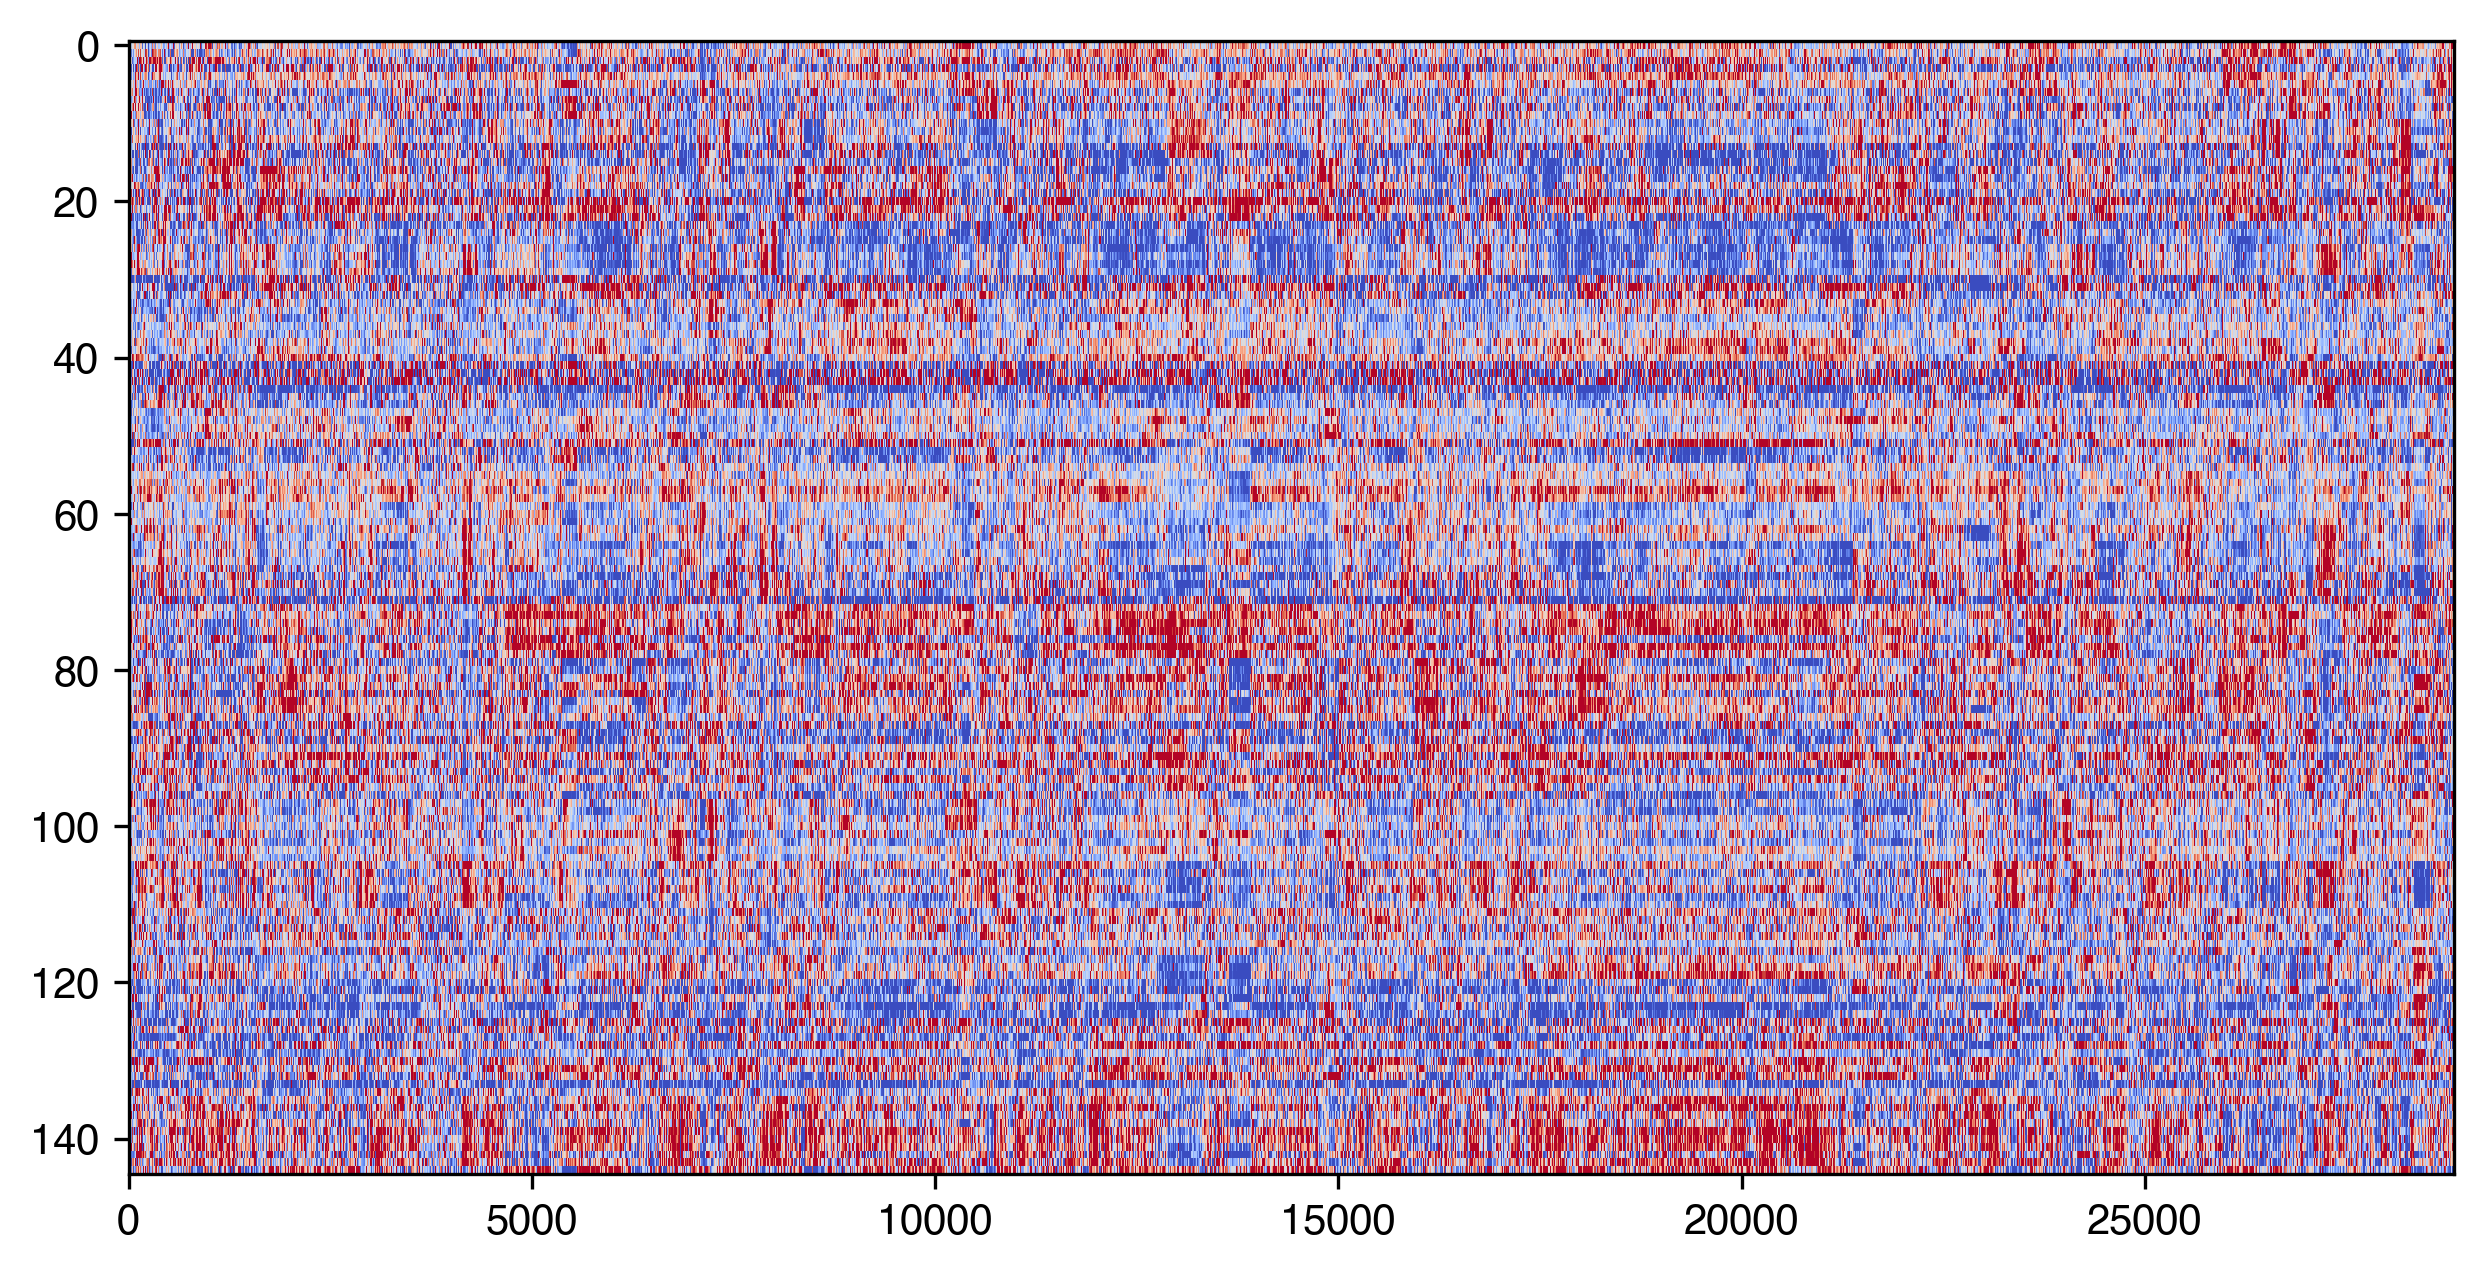

In [21]:
fig = plt.figure(figsize=(10, 5), dpi=300)
plt.imshow(chrombin_adata.X, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

## Calculate residual Corr

In [22]:
gene_data = chrombin_adata.X.T
total_dmr_data = dmr_adata.X.T

results = []
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    for i, chunk_start in enumerate(range(0, total_dmr_data.shape[0], chunk_size)):
        dmr_data = total_dmr_data[chunk_start:chunk_start+chunk_size, :]
        mask = dist_mask[chunk_start:chunk_start+chunk_size, :]
    
        future = executor.submit(chunk_corr,
                                 dmr_data=dmr_data, 
                                 gene_data=gene_data, 
                                 mask=mask,
                                 cutoff=0.2)
        futures[future] = i

    results = {}
    for future in as_completed(futures):
        chunk_id = futures[future]
        masked_pass_record = future.result()
        results[chunk_id] = masked_pass_record

# final concat
final_adata = anndata.AnnData(vstack((results[i] for i in range(len(results)))), 
                              obs=dmr_adata.var.copy(), 
                              var=chrombin_adata.var.copy())
final_adata

AnnData object with n_obs × n_vars = 187290 × 28829 

## Calculate Null Dist

In [23]:
# row is cluster
shuffled_bin_data_T = gene_data.T.copy()
shuffled_dmr_data_T = total_dmr_data.T.copy()

In [24]:
# shuffle axis 0 inplace
with ProcessPoolExecutor(cpu) as executor:
    futures = {}
    results = []
    for _ in range(repeat):
        # shuffle axis 0 in each repeat
        np.random.shuffle(shuffled_bin_data_T)
        np.random.shuffle(shuffled_dmr_data_T)
        
        # downsample DMR data, no need to use full DMR list to calc null
        if shuffled_dmr_data_T.shape[1] > dmr_sample:
            indices = np.random.choice(shuffled_dmr_data_T.shape[1], dmr_sample, replace=False)
            this_dmrs = shuffled_dmr_data_T[:, indices]
            this_mask = dist_mask[indices, :]
        else:
            this_mask = dist_mask
            this_dmrs = shuffled_dmr_data_T
        
        # downsample DMR data, no need to use full DMR list to calc null
        if shuffled_bin_data_T.shape[1] > bin_sample:
            indices = np.random.choice(shuffled_bin_data_T.shape[1], bin_sample, replace=False)
            this_bins = shuffled_bin_data_T[:, indices]
            this_mask = this_mask[:, indices]
        else:
            this_bins = shuffled_bin_data_T
        
        mask = dist_mask[chunk_start:chunk_start+chunk_size, :]
    
        future = executor.submit(chunk_corr,
                                 dmr_data=this_dmrs.T, 
                                 gene_data=this_bins.T, 
                                 mask=this_mask,
                                 cutoff=0)
        futures[future] = i

    for future in as_completed(futures):
        chunk_id = futures[future]
        masked_pass_record = future.result()
        results.append(masked_pass_record)

# final concat
final_null_result = vstack(results)

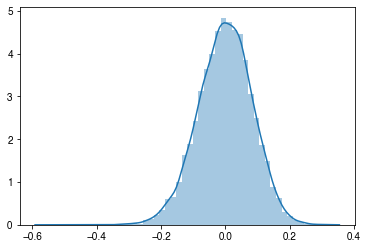

In [25]:
sns.distplot(np.random.choice(final_null_result.data, 10000, replace=False))

In [26]:
p_values = {}
for i in np.arange(0.3, 1, 0.005):
    total_n = final_null_result.data.size
    p = (final_null_result > i).sum() / total_n
    p_values[i] = p
p_values = pd.Series(p_values)
p_values = -np.log10(p_values)
p_values.replace(np.inf, 10, inplace=True)

In [27]:
p_values.values

array([ 4.14364225,  4.2200306 ,  4.31973351,  4.46867253,  4.58064629,
        4.68076144,  4.78990591,  4.93603394,  5.07073252,  5.20903522,
        5.51006521,  5.63500395,  5.63500395,  5.81109521,  5.81109521,
        5.81109521,  5.81109521,  5.81109521,  5.81109521,  5.81109521,
        5.81109521,  5.81109521,  5.81109521,  5.81109521,  5.81109521,
        5.81109521,  5.81109521,  5.81109521,  5.81109521,  5.81109521,
        5.81109521,  5.81109521,  6.1121252 ,  6.1121252 ,  6.1121252 ,
        6.1121252 , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.        ,
       10.        , 10.        , 10.        , 10.        , 10.  

In [28]:
cutoff = p_values[p_values > neg_logp_cutoff].index[0]
cutoff

0.3

In [29]:
# fig = plt.figure(figsize=(5, 10), dpi=300)
# plt.imshow(final_adata.X.todense(), cmap='viridis',
#            aspect='auto', vmin=cutoff, vmax=min(cutoff + 0.3, 1))

In [30]:
# sns.distplot(final_adata.X.data, kde=False, bins=100)

In [31]:
final_adata.X = final_adata.X.multiply(final_adata.X > cutoff)

In [32]:
final_adata.write_h5ad(f'{chrom}.h5ad')

In [33]:
final_adata

AnnData object with n_obs × n_vars = 187290 × 28829 

In [34]:
final_adata.X

<187290x28829 sparse matrix of type '<class 'numpy.float32'>'
	with 1267852 stored elements in Compressed Sparse Row format>